In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import rascals

rascals.setupOorb()
config = rascals.Config()

In [3]:
DATABASE = "../data/objects.db"
con = sql.connect(DATABASE)

**Notes**

_On MJDs and propagation intervals:_

It is important that this algorithm works with exposure times and not nights. This is actually a little trickier than it sounds because the dataset has been simplified to just having a single exposure time for each individual night. 

In the general case, we have a series of observations, at different exposure times $t_i$ in fields centered at ($\alpha_i$, $\delta_i$). To make sure the algorithm works "ground-up" using exposure times, one of the inputs for "rascalization" **needs** to be an array of exposure MJDs with varying intervals.




## Sections
[Plotting Code](#Plotting-Code)  
[Query Code](#Query-Code)  
[Class: Cell](#Class:-Cell)  
[Class: TestParticle](#Class:-TestParticle)  
[Function: rascalize](#Function:-rascalize)  
[Example](#Example)

#### Plotting Code

In [4]:
def _setAxes(ax, coordinateSystem):
    """
    Helper function to set axes limits depending on the coordinate system.
    
    """
    if coordinateSystem == "equatorialAngular":
        ax.set_xlabel(r"$\alpha$ [deg]")
        ax.set_ylabel(r"$\delta$ [deg]")
    elif coordinateSystem == "eclipticAngular":
        ax.set_xlabel(r"$\lambda$ [deg]")
        ax.set_ylabel(r"$\beta$ [deg]")
    elif coordinateSystem == "gnomonic":
        ax.set_xlabel(r"$\theta_X$ [deg]")
        ax.set_ylabel(r"$\theta_Y$ [deg]")
    else:
        raise ValueError("coordinateSystem should be one of: 'equatorialAngular', 'eclipticAngular', 'tangentPlane'")
    ax.set_aspect("equal")
    return

def plotCell(cell,
             coordinateSystem="equatorialAngular",
             scatterKwargs={"s":0.05}):
        
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = cell.observations["RA_deg"].values, 
        y = cell.observations["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = cell.observationst["lon_deg"].values, 
        y = cell.observations["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    #ax.set_xlim(*cell.xRange)
    #ax.set_ylim(*cell.yRange)
    
    if cell.shape == "circle":
        cell_p = plt.Circle((cell.center[0], cell.center[1]), np.sqrt(cell.area / np.pi), color="r", fill=False)
    elif cell.shape == "square":
        half_side = np.sqrt(fieldArea) / 2
        cell_p = plt.Rectangle((cell.center[0] - half_side, cell.center[1] - half_side), 2 * half_side, 2 * half_side, color="r", fill=False)
    else: 
        raise ValueError("Cell.shape should be one of 'square' or 'circle'")
    ax.add_artist(cell_p)
    ax.grid()
    return
    
def plotNight(night,
              cell=None,
              coordinateSystem="equatorialAngular",
              scatterKwargs={"s":0.05},
              scatterXlims=(0, 360),
              scatterYlims=(-90, 90)):
    
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = night["RA_deg"].values, 
        y = night["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = night["lon_deg"].values, 
        y = night["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    ax.set_xlim(scatterXlims)
    ax.set_ylim(scatterYlims)

    if cell is not None:
        cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
        ax.add_artist(cell_p)

    ax.grid()
    return

def plotRascals(dataframe, colorByObject=False, usePlotly=True, returnFig=False):
    if usePlotly is True:
        data = []
        if colorByObject is True:
            for name in dataframe["name"].unique():
                obj = dataframe[dataframe["name"] == name]
                trace = plotly.graph_objs.Scatter(
                    x=obj["theta_x_deg"],
                    y=obj["theta_y_deg"],
                    name=name,
                    mode="lines+markers",
                    marker=dict(size=2,
                                line=dict(width=2))
                )
                data.append(trace)
        else:
            trace = plotly.graph_objs.Scatter(
                x=dataframe["theta_x_deg"],
                y=dataframe["theta_y_deg"],
                mode="markers",
                text=dataframe["name"],
                marker=dict(size=2)
            )
            data.append(trace)
            
        layout = dict(
            width=550,
            height=550,
            autosize=False,
            title="",
            scene=dict(
                xaxis=dict(
                    title="Theta_X [deg]",
                ),
                yaxis=dict(
                    title="Theta_Y [deg]",
                ),
                aspectratio = dict(x=1, y=1)))
        
        fig = plotly.graph_objs.Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)
   
    else:
        fig, ax = plt.subplots(1, 1, dpi=200)
        if colorByObject is True:
            a, b = np.unique(dataframe["name"].values, return_inverse=True)
            hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())
            c = hex_map[b]
            ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
        else:
            c = "blue"

        dataframe.plot(x="theta_x_deg", y="theta_y_deg", kind="scatter", c=c, s=0.5, ax=ax)
        _setAxes(ax, "gnomonic")
    
    if returnFig is True:
        if usePlotly is True:
            return fig
        else: 
            return fig, ax

def plotRascals3D(dataframe, colorByObject=False):
    
    data = []
    if colorByObject is True:
        for name in dataframe["name"].unique():
            obj = dataframe[dataframe["name"] == name]
            trace = plotly.graph_objs.Scatter3d(
                x=obj["theta_x_deg"],
                y=obj["theta_y_deg"],
                z=obj["exp_mjd"] - dataframe["exp_mjd"].min(),
                name=name,
                mode="lines+markers",
                marker=dict(size=2,
                            line=dict(width=4))
            )
            data.append(trace)
    else:
        trace = plotly.graph_objs.Scatter3d(
            x=dataframe["theta_x_deg"],
            y=dataframe["theta_y_deg"],
            z=dataframe["exp_mjd"] - dataframe["exp_mjd"].min(),
            mode="markers",
            marker=dict(size=2)
            )
        data.append(trace)

    layout = dict(
        width=800,
        height=550,
        autosize=False,
        title="",
        scene=dict(
            xaxis=dict(
                title="Theta_X [deg]",
            ),
            yaxis=dict(
                title="Theta_Y [deg]",
            ),
            zaxis=dict(
                title="Days [MJD]",
            ),
            aspectratio = dict(x=1, y=1, z=1)))

    fig = plotly.graph_objs.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

#### Query Code

In [5]:
def createQuery(queryType,
                observationColumns=config.observationColumns,
                truthColumns=config.truthColumns):
    if queryType == "observation":
        columns = list(config.observationColumns.values())
    elif queryType == "truth":
        columns = list(config.observationColumns.values()) + list(config.truthColumns.values())
    else:
        raise ValueError("queryType should be one of 'observation' or 'truth'")
    query = '"' + '", "'.join(columns) + '"'
    return query

def queryNight(con,
               night,
               queryType="observation",
               observationColumns=config.observationColumns,
               truthColumns=config.truthColumns):
    
    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    night_df = pd.read_sql("""SELECT {} FROM ephemeris
                              WHERE night = {}""".format(query, night), con)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    night_df.rename(columns=inverseMapping, inplace=True)
    return night_df

def queryCell(con,
              cell,
              queryType="observation",
              chunksize=50000,
              observationColumns=config.observationColumns,
              truthColumns=config.truthColumns):

    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    
    chunks = []
    for chunk in pd.read_sql("""SELECT {0} FROM ephemeris
                                 WHERE (({1} >= {2} AND {1} <= {3})
                                 AND ({4} >= {5} AND {4} <= {6})
                                 AND ({7} >= {8} AND {7} <= {9}))""".format(query,
                                                                            observationColumns["exp_mjd"],
                                                                            *cell.mjdRange,
                                                                            observationColumns["RA_deg"],
                                                                            *cell.xRange,
                                                                            observationColumns["Dec_deg"],
                                                                            *cell.yRange), 
                             con,
                             chunksize=chunksize):
        chunks.append(chunk)
    
    cell_df = pd.concat(chunks)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    cell_df.rename(columns=inverseMapping, inplace=True)                                                                    

    keep = rascals.findObsInCell(cell_df["obs_id"].values,
                                 cell_df[["RA_deg", "Dec_deg"]].as_matrix(),
                                 cell.center,
                                 cell.radius)
    cell_df = cell_df[cell_df["obs_id"].isin(keep)]
    return cell_df

def getObservations(raRange,
                    decRange,
                    mjdRange,
                    con,
                    queryType="truth",
                    observationColumns=config.observationColumns,
                    truthColumns=config.truthColumns): 
        
        query = createQuery(queryType,
                            observationColumns=observationColumns,
                            truthColumns=truthColumns)
        
        observations = pd.read_sql("""
            SELECT {0} FROM ephemeris
            WHERE (({1} >= {2} AND {1} <= {3})
            AND ({4} >= {5} AND {4} <= {6})
            AND ({7} >= {8} AND {7} <= {9}))
        """.format(query,
                   observationColumns["exp_mjd"],
                   *mjdRange,
                   observationColumns["RA_deg"],
                   *raRange,
                   observationColumns["Dec_deg"],
                   *decRange), con)

        columnMapping = {**observationColumns, **truthColumns}
        inverseMapping = {value : key for key, value in columnMapping.items()}
        observations.rename(columns=inverseMapping, inplace=True)
        print("Found {} observations.".format(len(observations)))
        return observations


#### Class: Cell

In [6]:
from rascals import Cell

#### Class: TestParticle

In [7]:
from rascals import TestParticle

#### Function: rascalize

In [8]:
from rascals import rascalize

#### Example

Let us see what a night of data looks like

In [9]:
night = queryNight(con, 59582)

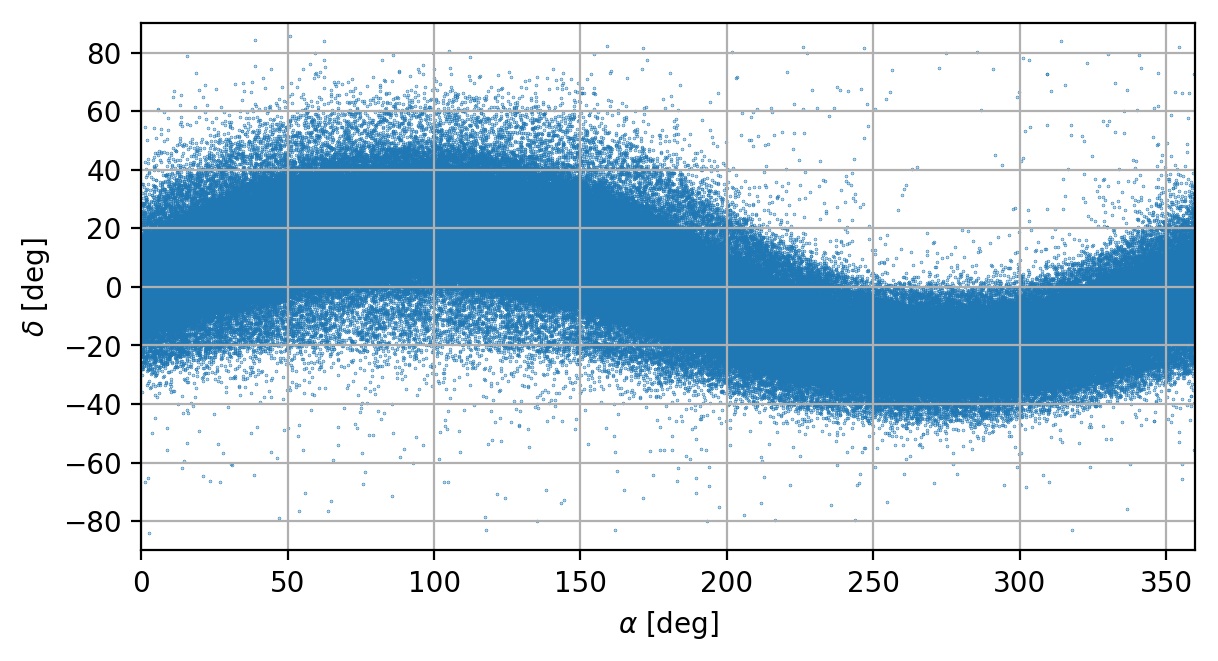

In [10]:
plotNight(night)

Load some 'observations' into a dataframe

In [11]:
raRange = [180, 230]
decRange = [-30, -10]
mjdRange = [59582, 59582 + 30]
observations = getObservations(raRange, decRange, mjdRange, con)

Found 1583197 observations.


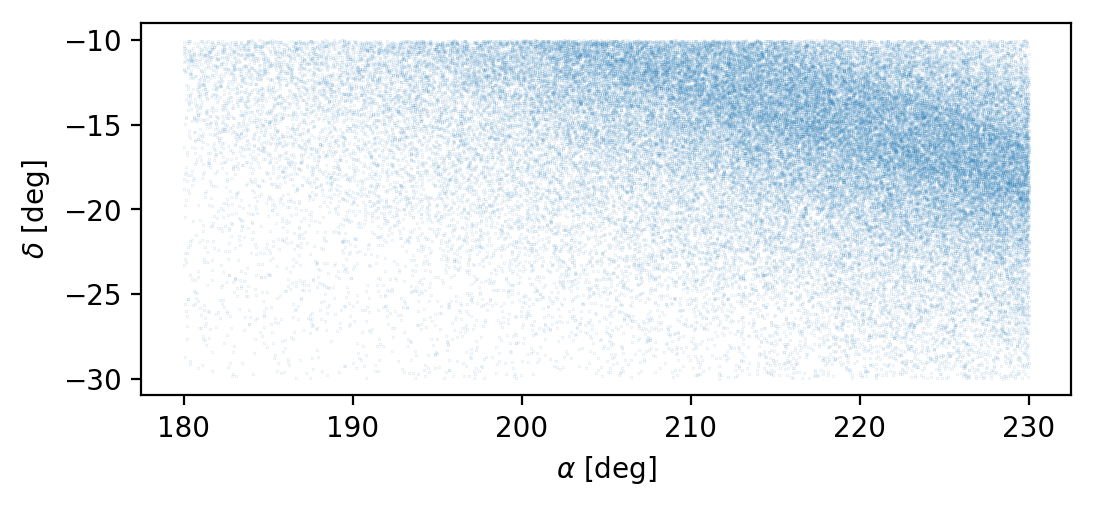

In [12]:
ra = observations[observations["night"] == 59582]["RA_deg"].values
dec = observations[observations["night"] == 59582]["Dec_deg"].values

fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(ra, dec, s=0.001)
_setAxes(ax, "equatorialAngular")
ax.set_aspect("equal")

Define an initial cell

In [22]:
observations["exp_mjd"].values[0]

59582.172999999297

In [23]:
cell = Cell([199.8, -19.8], observations["exp_mjd"].values[0], area=1, shape="circle", dataframe=observations)
cell.getObservations()

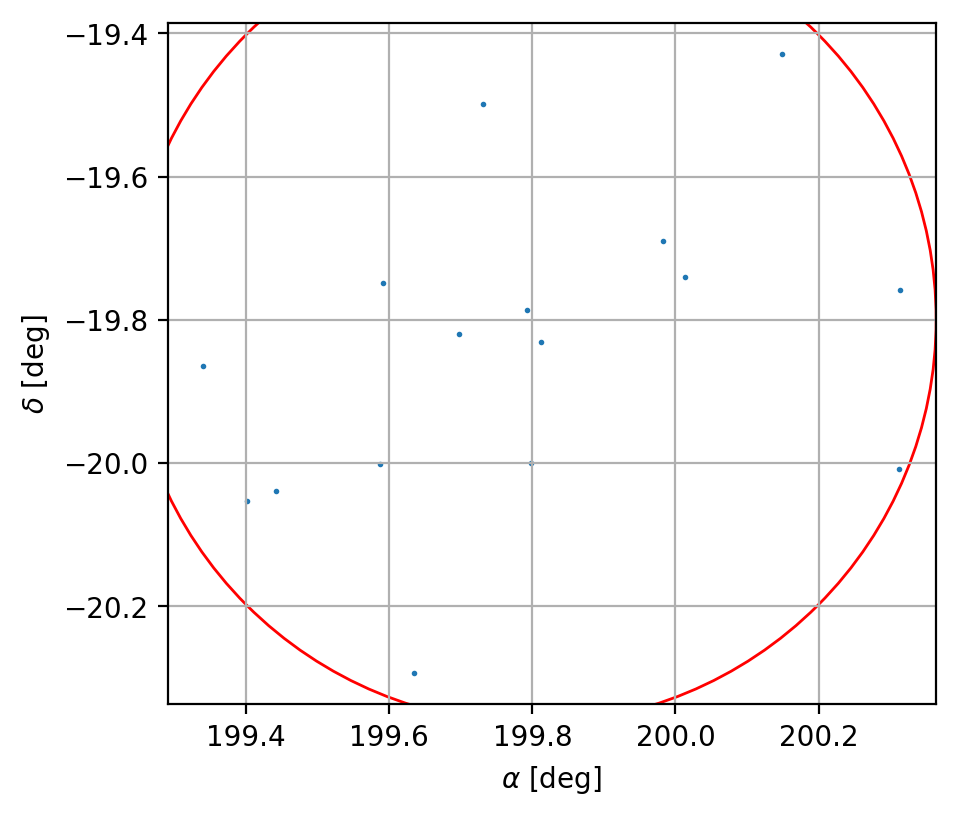

In [24]:
plotCell(cell, scatterKwargs={"s": 1})

In [25]:
print("r [AU]:\n min: {}\n max: {}\n median: {}".format(cell.observations["r_au"].min(),
                                                        cell.observations["r_au"].max(),
                                                        cell.observations["r_au"].median()))

r [AU]:
 min: 1.8270287254
 max: 3.2926623455
 median: 2.8071909353999995


In [26]:
# For now lets take the object which has the median barycentric distance, lets also grab its velocity
real_object = cell.observations[cell.observations["name"] == "U3160"]
velocity_ec_cart = real_object[["obj_dx/dt_au_p_day", "obj_dy/dt_au_p_day", "obj_dz/dt_au_p_day"]].values[0]
x_e = real_object[["obs_x_au","obs_y_au", "obs_z_au"]].values[0]
r = real_object["r_au"].values[0]
mjd = real_object["exp_mjd"].values[0]

In [17]:
r = pd.read_sql("""SELECT * FROM ephemeris LIMIT 10""", con)

In [21]:
r["mjd_utc"].values[0]

59580.172999999297

In [27]:
cell = Cell([199.8, -19.8], observations["exp_mjd"].values[0], area=1.0, shape="circle", dataframe=observations)
particle = TestParticle(cell.center, r, velocity_ec_cart, x_e, mjd)
mjds = observations["exp_mjd"].unique()

In [28]:
rascals_df, cells, particles = rascalize(cell, particle, mjds, verbose=False)

In [29]:
plotRascals(rascals_df)

In [30]:
plotRascals(rascals_df, colorByObject=True)

In [31]:
plotRascals3D(rascals_df)

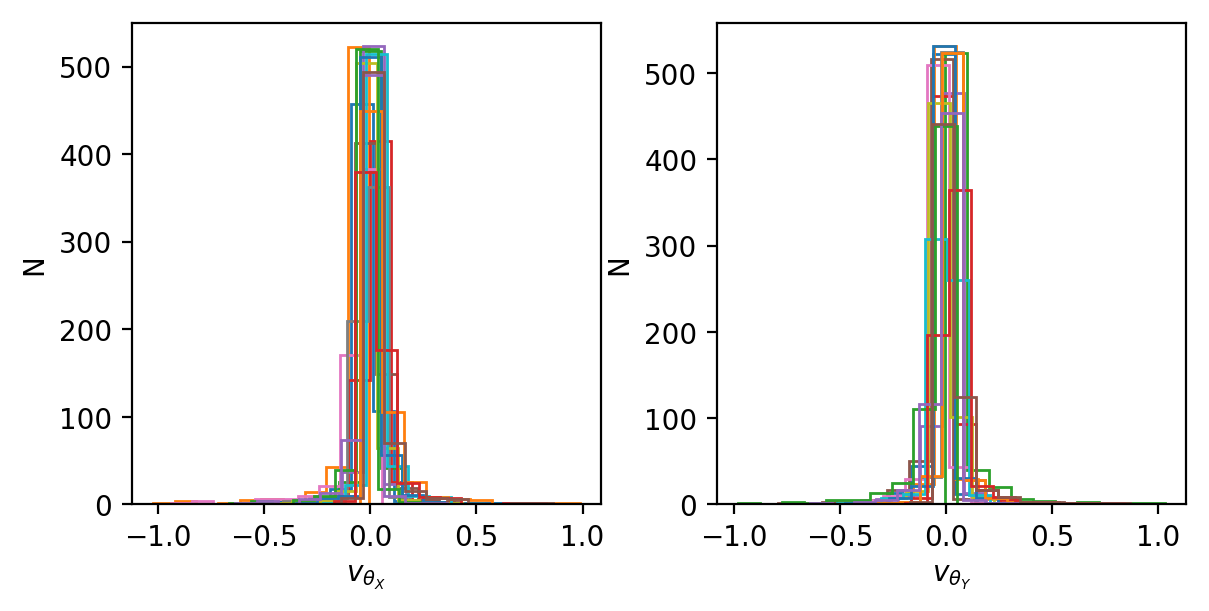

In [32]:
theta_x = rascals_df["theta_x_deg"].values
theta_y = rascals_df["theta_y_deg"].values
mjd = rascals_df["exp_mjd"].values
truth = rascals_df["name"].values

# Select detections in first exposure:
first = np.where(mjd == mjd.min())[0]
theta_x0 = theta_x[first]
theta_y0 = theta_y[first]
mjd0 = mjd[first][0]
dt = mjd - mjd0

# Grab remaining detections
remaining = np.where(mjd != mjd.min())[0]

vx = {}
vy = {}
for i in range(len(first)):
    vx[i] = (theta_x[remaining] - theta_x0[i]) / dt[remaining]
    vy[i] = (theta_y[remaining] - theta_y0[i]) / dt[remaining]
    
fig, ax = plt.subplots(1, 2, dpi=200)
fig.set_size_inches(6, 3)
fig.tight_layout()

for k, v in vx.items():
    ax[0].hist(v, histtype="step", bins=10)
ax[0].set_xlabel(r"$v_{\theta_X}$")

for k, v in vy.items():
    ax[1].hist(v, histtype="step", bins=10)
ax[1].set_xlabel(r"$v_{\theta_Y}$")

for a in ax:
    a.set_ylabel("N");

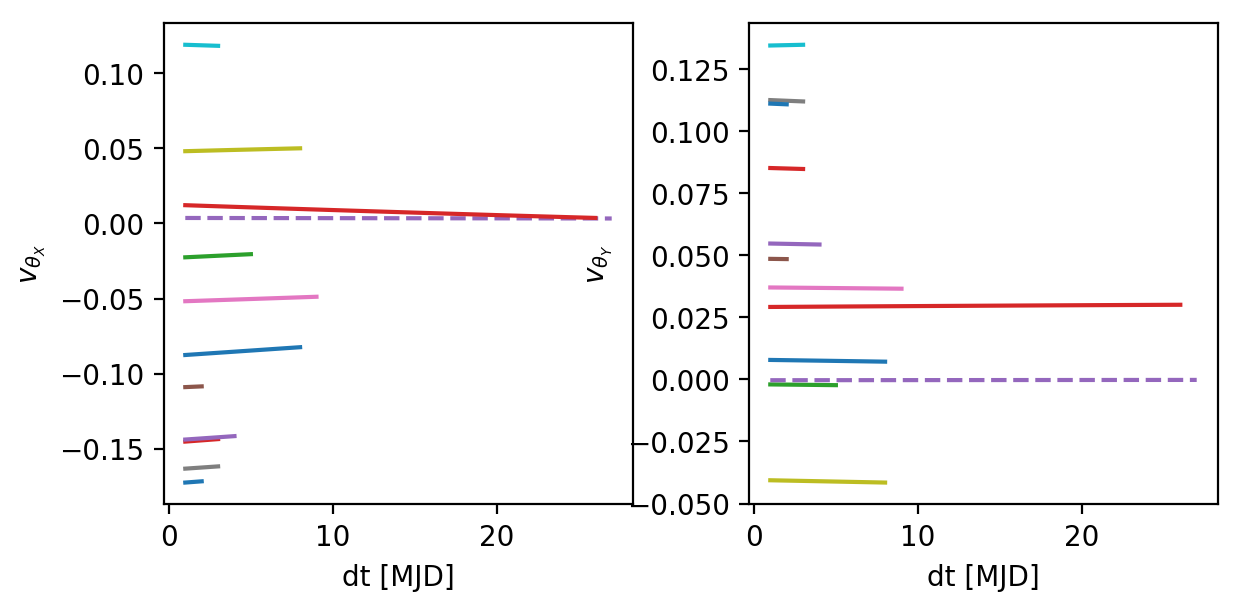

In [33]:
fig, ax = plt.subplots(1, 2, dpi=200)
fig.set_size_inches(6, 3)
fig.tight_layout()

uniqueObjects = rascals_df[rascals_df["exp_mjd"] == rascals_df["exp_mjd"].min()]["name"].unique()
for name in uniqueObjects:
    singleObject = rascals_df[(rascals_df["name"] == name)]
    theta_x = singleObject["theta_x_deg"].values
    theta_y = singleObject["theta_y_deg"].values
    mjd = singleObject["exp_mjd"].values
    
    first = np.where(mjd == mjd.min())[0]
    theta_x0 = theta_x[first]
    theta_y0 = theta_y[first]
    mjd0 = mjd[first][0]
    dt = mjd - mjd0
    
    remaining = np.where(mjd != mjd.min())[0]

    vx = (theta_x[remaining] - theta_x0) / dt[remaining]
    vy = (theta_y[remaining] - theta_y0) / dt[remaining]
    
    if name == "U3160":
        ls = "--"
    else:
        ls = "-"
        
    ax[0].plot(dt[remaining], vx, ls=ls)
    ax[0].set_ylabel(r"$v_{\theta_X}$")
    ax[1].plot(dt[remaining], vy, ls=ls)
    ax[1].set_ylabel(r"$v_{\theta_Y}$")
    
for a in ax:
    a.set_xlabel("dt [MJD]")


In [34]:
from functools import partial
import multiprocessing as mp
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [35]:
def clusterVelocity(obs_ids, theta_x, theta_y, dt, vx, vy, eps=0.005, min_samples=3):
    xx = theta_x - vx * dt
    yy = theta_y - vy * dt
    X = np.vstack([xx, yy]).T  
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    
    clusters = db.labels_[np.where(db.labels_ != -1)[0]]
    cluster_ids = []
    
    if len(clusters) != 0:
        for cluster in np.unique(clusters):
            cluster_ids.append(obs_ids[np.where(db.labels_ == cluster)[0]])
    else:
        cluster_ids = -1
    
    del db
    return cluster_ids
           
def _clusterVelocity(vx, vy,
                     obs_ids=None,
                     theta_x=None,
                     theta_y=None,
                     dt=None,
                     eps=None,
                     min_samples=None):
    return clusterVelocity(obs_ids,
                           theta_x,
                           theta_y,
                           dt,
                           vx,
                           vy,
                           eps=eps,
                           min_samples=min_samples) 

In [36]:
def findClusters(detections, gridpoints=10000, threads=10, eps=0.005, min_samples=3, verbose=True):
    
    # Extract useful quantities
    obs_ids = detections["obs_id"].values
    theta_x = detections["theta_x_deg"].values
    theta_y = detections["theta_y_deg"].values
    mjd = detections["exp_mjd"].values
    truth = detections["name"].values

    # Select detections in first exposure
    first = np.where(mjd == mjd.min())[0]
    theta_x0 = theta_x[first]
    theta_y0 = theta_y[first]
    mjd0 = mjd[first][0]
    dt = mjd - mjd0

    # Grab remaining detections
    remaining = np.where(mjd != mjd.min())[0]
    
    # Create min, max velocity variables
    vx_max = 0
    vx_min = 0
    vy_max = 0
    vy_min = 0
    
    # Calculate the velocity from every detection in the first exposure
    # to every detection in the following exposures. Keep the max and min
    # for both x and y.
    if verbose:
        print("Calculating velocity ranges...")
        
    for i in first:
        vx = (theta_x[remaining] - theta_x0[i]) / dt[remaining]
        vy = (theta_y[remaining] - theta_y0[i]) / dt[remaining]
        if np.min(vx) < vx_min:
            vx_min = np.min(vx)
        if np.max(vx) > vx_max:
            vx_max = np.max(vx)
        if np.min(vy) < vy_min:
            vy_min = np.min(vy)
        if np.max(vy) > vy_max:
            vy_max = np.max(vy)
            
    if verbose:
        print("Maximum possible x velocity range: {:.4e} to {:.4e}".format(vx_min, vx_max))
        print("Maximum possible y velocity range: {:.4e} to {:.4e}".format(vy_min, vy_max))
        
    # Define velocity grid
    possible_vx = np.linspace(vx_min, vx_max, num=int(np.sqrt(gridpoints)))
    possible_vy = np.linspace(vy_min, vy_max, num=int(np.sqrt(gridpoints)))
    vxx, vyy = np.meshgrid(possible_vx, possible_vy)
    vxx = vxx.flatten()
    vyy = vyy.flatten()
    
    if verbose:
        print("Running velocity space clustering.")
    
    possible_clusters = []
    if threads > 1:
        if verbose:
            print("Using {} threads".format(threads))
        p = mp.Pool(threads)
        possible_clusters = p.starmap(partial(_clusterVelocity, 
                                              obs_ids=obs_ids,
                                              theta_x=theta_x,
                                              theta_y=theta_y,
                                              dt=dt,
                                              eps=eps,
                                              min_samples=min_samples),
                                              zip(vxx.T, vyy.T))
        p.close()
    else:
        possible_clusters = []
        for vxi, vyi in zip(vxx, vyy):
            possible_clusters.append(_clusterVelocity(vxi, vyi))
    
    # Clean up returned arrays and remove empty cases
    populated_clusters = []
    populated_cluster_velocities = []
    for cluster, vxi, vyi in zip(possible_clusters, vxx, vyy):
        if type(cluster) == int:
            continue
        else:
            populated_clusters.append(cluster)
            populated_cluster_velocities.append([vxi, vyi])
            
    if verbose:
        print("Found {} cluster groups.".format(len(populated_clusters)))

    return populated_clusters, populated_cluster_velocities, dt

In [37]:
def analyzeClusters(clusters, velocities, detections, min_detections_accepted=5, min_samples=10):
    
    true_clusters = []
    true_cluster_velocities = []
    partial_clusters = []
    partial_cluster_velocities = []
    found_objects = []
    partial_objects = []
    false_clusters = []
    
    all_names = detections["name"].values
    all_unique_names, all_unique_counts = np.unique(all_names, return_counts=True)

    print("Number of unique objects: {}".format(len(all_unique_names)))
    print("Number of unique objects with at least {} detections: {}".format(min_samples, len(np.where(all_unique_counts >= min_samples)[0])))
    
    for c, v in zip(clusters, velocities):
        for individual_cluster in c:
            names = detections[detections["obs_id"].isin(individual_cluster)]["name"].values
            unique_names, unique_name_counts = np.unique(names, return_counts=True)
            unique_names_thresh = unique_names[np.where(unique_name_counts >= min_detections_accepted)[0]]
            
            if len(unique_names) == 1: 
                true_clusters.append(c)
                found_objects.append(np.unique(unique_names[0]))
                true_cluster_velocities.append(v)
            if len(unique_names_thresh) == 1 and len(unique_names) != 1:
                partial_clusters.append(c)
                partial_objects.append(np.unique(unique_names_thresh[0]))
                partial_cluster_velocities.append(v)
            else:
                false_clusters.append(c)
    
    #return np.array(found_objects)
    #return true_clusters, true_cluster_velocities, np.array(found_objects).T, false_clusters
    a = len(np.unique(np.array(found_objects).T))
    b = len(np.unique(np.array(partial_objects).T))
    c = len(np.unique(np.array(partial_objects + found_objects).T))
    
    print("Number of unique objects found in pure clusters: {}".format(a))
    print("Number of unique objects found in contaminated clusters: {}".format(b))
    print("Number of unique objects found: {}".format(c))
    print("Completeness: {}".format(c / len(np.where(all_unique_counts >= min_samples)[0])))
    print("False clusters: {}".format(len(np.array(false_clusters))))
    return

In [38]:
a, b, c = findClusters(rascals_df, gridpoints=10000)

Calculating velocity ranges...
Maximum possible x velocity range: -1.0230e+00 to 9.8605e-01
Maximum possible y velocity range: -9.7847e-01 to 1.0301e+00
Running velocity space clustering.
Using 10 threads
Found 30 cluster groups.


In [39]:
analyzeClusters(a, b, rascals_df)

Number of unique objects: 88
Number of unique objects with at least 10 detections: 17
Number of unique objects found in pure clusters: 19
Number of unique objects found in contaminated clusters: 0
Number of unique objects found: 19
Completeness: 1.1176470588235294
False clusters: 38


In [40]:

#a, b = np.unique(rascals_df["name"].values, return_inverse=True)
#hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())
#c = hex_map[b]
   
#fig, ax = plt.subplots(1, 1, dpi=150)
#ax.scatter(xx, yy, s=0.1, c=c)


possible_vx = np.linspace(-0.3, 0.15, num=10)
possible_vy = np.linspace(-0.15, 0.15, num=10)
vxx, vyy = np.meshgrid(possible_vx, possible_vy)
vxx = vxx.flatten()
vyy = vyy.flatten()

theta_x = rascals_df["theta_x_deg"].values
theta_y = rascals_df["theta_y_deg"].values
mjd = rascals_df["exp_mjd"].values
truth = rascals_df["name"].values

# Select detections in first exposure:
first = np.where(mjd == mjd.min())[0]
theta_x0 = theta_x[first]
theta_y0 = theta_y[first]
mjd0 = mjd[first][0]
dt = mjd - mjd0

# Grab remaining detections
remaining = np.where(mjd != mjd.min())[0]

velocitys = ["{:.2}, {:.2}".format(x, y) for x, y in zip(vxx, vyy)]
        
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

figure['layout']['height']= 800
figure['layout']['width'] = 800
figure['layout']['xaxis'] = { 'title': 'theta_X', 'range': [-10, 10]}
figure['layout']['yaxis'] = { 'title': 'theta_Y', 'range': [-10, 10]}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': velocitys[0],
    'plotlycommand': 'animate',
    'values': velocitys,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Velocity:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}


xx = theta_x[remaining] + vxx[0] * dt[remaining]
yy = theta_y[remaining] + vyy[0] * dt[remaining]

for name in np.unique(truth[remaining]):
    mask = np.where(truth[remaining] == name)[0]
    data_dict = {
        'x': xx[mask],
        'y': yy[mask],
        'mode': 'markers',
        'text': name,
        'marker': {
            'size': 3
        },
        'name': name
    }
    figure['data'].append(data_dict)
    

for v, vxii, vyii in zip(velocitys, vxx, vyy):
    xx = theta_x[remaining] + vxii * dt[remaining]
    yy = theta_y[remaining] + vyii * dt[remaining]
    
    frame = {'data': [], 'name': v}
    for name in np.unique(truth[remaining]):
        mask = np.where(truth[remaining] == name)[0]
        data_dict = {
                'x': xx[mask],
                'y': yy[mask],
                'mode': 'markers',
                'text': name,
                'marker': {
                    'size': 3
                },
                'name': name
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [v],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
         'transition': {'duration': 300}}
     ],
     'label': v,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    

plotly.offline.plot(figure, filename="velocity.html")


'file:///Users/joachim/repos/RaSCaLS/notebooks/velocity.html'

*** DO NOT RUN BELOW ***

In [ ]:
def animateRascals(cell, particle, mjds, r_range, r_step=0.5, colorByObject=True):
    
    
    ri = np.arange(r_range[0], r_range[1]+r_step, r_step)

    figure = {
        'data': [],
        'layout': {},
        'frames': []
    }

    figure['layout']['height']= 800
    figure['layout']['width'] = 800
    figure['layout']['xaxis'] = { 'title': 'theta_X'}
    figure['layout']['yaxis'] = { 'title': 'theta_Y'}
    figure['layout']['hovermode'] = 'closest'
    figure['layout']['sliders'] = {
        'args': [
            'transition', {
                'duration': 400,
                'easing': 'cubic-in-out'
            }
        ],
        'initialValue': ri[0],
        'plotlycommand': 'animate',
        'values': ri,
        'visible': True
    }
    figure['layout']['updatemenus'] = [
        {
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': False},
                             'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                    'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]
    
    sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'r:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
    }
 
    particle.r = ri[0]
    dataframe, cells, particles = rascalize(cell, particle, mjds, verbose=False)
    if colorByObject is True:
        for name in dataframe["name"].unique(): 
            obj = dataframe[dataframe["name"] == name]
            data_dict = {
                'x': obj["theta_x_deg"],
                'y': obj["theta_y_deg"],
                'mode': 'markers',
                'text': name,
                'marker': {
                    'size': 3,
                },
                'name': name
            }
            figure['data'].append(data_dict)
    else:
        obj = dataframe
        data_dict = {
            'x': obj["theta_x_deg"],
            'y': obj["theta_y_deg"],
            'mode': 'markers',
            'text': None,
            'marker': {
                'size': 3,
            },
            'name': None
        }
        figure['data'].append(data_dict)



    for r in ri:
        particle.r = r
        dataframe, cells, particles = rascalize(cell, particle, mjds, verbose=False)

        frame = {'data': [], 'name': r}
        if colorByObject is True:
            for name in dataframe["name"].unique(): 
                obj = dataframe[dataframe["name"] == name]
                data_dict = {
                    'x': obj["theta_x_deg"],
                    'y': obj["theta_y_deg"],
                    'mode': 'markers',
                    'text': name,
                    'marker': {
                        'size': 3,
        
                    },
                    'name': name
                }
                frame['data'].append(data_dict)
        else:
            obj = dataframe
            data_dict = {
                'x': obj["theta_x_deg"],
                'y': obj["theta_y_deg"],
                'mode': 'markers',
                'text': None,
                'marker': {
                    'size': 3,
                },
                'name': None
            }
            frame['data'].append(data_dict)
        
        figure['frames'].append(frame)
        slider_step = {'args': [
            [r],
            {'frame': {'duration': 300, 'redraw': False},
             'mode': 'immediate',
             'transition': {'duration': 300}}
         ],
         'label': r,
         'method': 'animate'}
        sliders_dict['steps'].append(slider_step)


    figure['layout']['sliders'] = [sliders_dict]

    plotly.offline.plot(figure, filename="heliocentric.html")
    return 

In [ ]:
cell = Cell([199.8, -19.8], 1.0, 59582, dataframe=observations)
particle = TestParticle(cell.center, 2.0, velocity_ec_cart, x_e, mjd)
mjds = observations["exp_mjd"].unique()
dataframe, cells, particles = rascalize(cell, particle, mjds, verbose=False)
animateRascals(cell, particle, mjds, [1.5, 3.0], r_step=0.05)